In [1]:
# %%
import sys
import os
import json
from os.path import join
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import *
from core.network_edm_lib import SongUNet, DhariwalUNet
from circuit_toolkit.plot_utils import saveallforms, to_imgrid, show_imgrid

In [16]:
def extract_patches(images, patch_size, patch_stride):
    B, C, H, W = images.shape
    patches = images.unfold(2, patch_size, patch_stride).unfold(3, patch_size, patch_stride)
    patches = patches.contiguous().view(B, C, -1, patch_size, patch_size)
    patches = patches.permute(0, 2, 1, 3, 4).contiguous().view(-1, C, patch_size, patch_size)
    return patches


In [3]:
saveroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"
# savedir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_4blocks_noattn"
savedir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/FFHQ_UNet_CNN_EDM_4blocks_wide64_attn_pilot_fixednorm"
sampledir = join(savedir, "samples")

In [15]:
# samples_epoch_000001.pt
# load and save them in the same order 
from glob import glob
import re
sample_paths = sorted(glob(join(sampledir, "samples_epoch_*.pt")), key=lambda x: int(re.findall(r'\d+', x)[0]))
sample_store = {}
for sample_path in tqdm(sample_paths):
    filename = os.path.basename(sample_path)
    match = re.match(r'samples_epoch_(\d+)\.pt', filename)
    if match:
        epoch = int(match.group(1))
        sample_store[epoch] = torch.load(sample_path)
    else:
        print(f"Warning: could not extract epoch from filename: {filename}")
# with open(f"{savedir}/sample_store.pkl", "rb") as f:
#     sample_store = pkl.load(f)

  0%|          | 0/348 [00:00<?, ?it/s]

In [3]:
# with open(f"{savedir}/sample_cov_true_eigenbasis_diag_traj.pkl", "rb") as f:
#     data = pkl.load(f)
# diag_cov_x_sample_true_eigenbasis_traj = data["diag_cov_x_sample_true_eigenbasis_traj"]
# mean_x_sample_traj = data["mean_x_sample_traj"]
# cov_x_sample_traj = data["cov_x_sample_traj"]
# true_cov_eigs = data["true_cov_eigs"]
# step_slice = data["step_slice"]

In [10]:
# with open(f"{savedir}/train_data_cov_info.pkl", "rb") as f:
#     data = pkl.load(f)
# Xtsr = data["train_pnts"]
# X_mean = data["X_mean"]
# rot = data["rot"]
# diag_var = data["diag_var"]
# cov_empirical = data["cov_empirical"]
# ndim = Xtsr.shape[1]

### Load data

In [17]:
import sys
sys.path.append("/n/home12/binxuwang/Github/edm")
from training.dataset import TensorDataset, ImageFolderDataset

edm_dataset_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/datasets"
edm_ffhq64_path = join(edm_dataset_root, "ffhq-64x64.zip")
ffhq64_dataset = ImageFolderDataset(edm_ffhq64_path)
ffhq64_Xtsr = torch.stack([torch.from_numpy(ffhq64_dataset[i][0]) for i in range(len(ffhq64_dataset))]) / 255.0
Xtsr = (ffhq64_Xtsr - 0.5) / 0.5
imgshape = Xtsr.shape[1:]

In [25]:
device = "cuda"

### Organized functions

In [89]:
def process_patch_mean_cov_statistics(images, sample_store, savedir, patch_size=8, patch_stride=4, device="cuda", imgshape=(3, 64, 64)):
    # images = Xtsr.view(Xtsr.shape[0], *imgshape)
    patches = extract_patches(images, patch_size=patch_size, patch_stride=patch_stride)
    patch_shape = patches.shape[1:]
    patch_dim = np.prod(patch_shape)
    patch_mean = patches.mean(dim=0)
    patch_cov = torch.cov(patches.view(patches.shape[0], -1).T)
    patch_eigval, patch_eigvec = torch.linalg.eigh(patch_cov.to(device))
    patch_eigval = patch_eigval.flip(0)
    patch_eigvec = patch_eigvec.flip(1)
    patch_eigvec = patch_eigvec.to(device)
    print(f"patch_cov.shape: {patch_eigval.shape} computed on {images.shape[0]} images")
    mean_x_patch_sample_traj = []
    cov_x_patch_sample_traj = []
    diag_cov_x_patch_sample_true_eigenbasis_traj = []
    step_slice = sorted([*sample_store.keys()])
    
    for training_step in tqdm(step_slice):
        x_final = sample_store[training_step]
        if isinstance(x_final, tuple):
            x_final = x_final[0]
        x_final_patches = extract_patches(x_final.view(x_final.shape[0], *imgshape), patch_size=patch_size, patch_stride=patch_stride)
        x_final_patches = x_final_patches.view(x_final_patches.shape[0], -1)
        mean_x_patch_sample = x_final_patches.mean(dim=0)
        cov_x_patch_sample = torch.cov(x_final_patches.T)
        mean_x_patch_sample_traj.append(mean_x_patch_sample.cpu())
        
        # Estimate the variance along the eigenvector of the covariance matrix
        cov_x_patch_sample_true_eigenbasis = patch_eigvec.T @ cov_x_patch_sample @ patch_eigvec
        diag_cov_x_patch_sample_true_eigenbasis = torch.diag(cov_x_patch_sample_true_eigenbasis)
        diag_cov_x_patch_sample_true_eigenbasis_traj.append(diag_cov_x_patch_sample_true_eigenbasis.cpu())
        cov_x_patch_sample_traj.append(cov_x_patch_sample.cpu())
    
    mean_x_patch_sample_traj = torch.stack(mean_x_patch_sample_traj).cpu()
    cov_x_patch_sample_traj = torch.stack(cov_x_patch_sample_traj).cpu()
    diag_cov_x_patch_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_patch_sample_true_eigenbasis_traj).cpu()

    pkl.dump({
        "diag_cov_x_patch_sample_true_eigenbasis_traj": diag_cov_x_patch_sample_true_eigenbasis_traj, 
        "mean_x_patch_sample_traj": mean_x_patch_sample_traj,
        "cov_x_patch_sample_traj": cov_x_patch_sample_traj,
        "patch_mean": patch_mean.cpu(),
        "patch_cov": patch_cov.cpu(),
        "patch_eigval": patch_eigval.cpu(),
        "patch_eigvec": patch_eigvec.cpu(),
        "step_slice": step_slice
    }, open(f"{savedir}/sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj.pkl", "wb"))
    print(f"Saved to {savedir}/sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj.pkl")
    return patch_mean, patch_cov, patch_eigval, patch_eigvec, mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj
    
# Example usage:
# process_patch_statistics(Xtsr, sample_store, savedir, device)

In [50]:
def plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval, slice2plot,
                               patch_size, patch_stride, savedir, dataset_name="FFHQ64"):
    ndim = patch_eigval.shape[0]
    max_eigid = max(range(ndim)[slice2plot])    
    plt.figure()
    plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
    for i, eigid in enumerate(range(ndim)[slice2plot]):
        plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Training step")
    plt.ylabel("Variance")
    plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | {dataset_name}")
    plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
    saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw_top{max_eigid}")
    plt.show()

    plt.figure()
    diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
    plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
    plt.axhline(1, color="k", linestyle="--", alpha=0.7)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Training step")
    plt.ylabel("Variance [normalized by target variance]")
    plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | {dataset_name}")
    plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
    saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized_top{max_eigid}")
    plt.show()

# Example usage:
# plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval, patch_size, patch_stride, savedir)

In [76]:
def plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean, patch_eigvec, patch_eigval, 
                                     slice2plot, patch_size, patch_stride, savedir, dataset_name="FFHQ64"):
    patch_mean_vec = patch_mean.view(-1)
    mean_deviation_traj = (mean_x_patch_sample_traj - patch_mean_vec) @ patch_eigvec.cpu()
    MSE_per_mode_traj = mean_deviation_traj.pow(2)
    MSE_per_mode_traj_normalized = MSE_per_mode_traj / patch_eigval

    ndim = patch_eigval.shape[0]
    max_eigid = max(range(ndim)[slice2plot])    

    plt.figure()
    plt.plot(step_slice, mean_deviation_traj[:, slice2plot], alpha=0.7)
    plt.xscale("log")
    plt.xlabel("Training step")
    plt.ylabel("mean deviation")
    plt.title(f"Mean deviation of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | {dataset_name}")
    plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
    saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_mean_dev_eigenbasis_traj_raw_top{max_eigid}")
    plt.show()

    plt.figure()
    plt.plot(step_slice, MSE_per_mode_traj[:, slice2plot], alpha=0.7)
    plt.xscale("log")
    plt.xlabel("Training step")
    plt.ylabel("Squared error of mean deviation")
    plt.title(f"Mean deviation of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | {dataset_name}")
    plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
    saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_mean_SE_eigenbasis_traj_raw_top{max_eigid}")
    plt.show()

    plt.figure()
    plt.plot(step_slice, MSE_per_mode_traj_normalized[:, slice2plot], alpha=0.7)
    plt.xscale("log")
    plt.xlabel("Training step")
    plt.ylabel("Squared error of mean deviation\n[normalized by target variance]")
    plt.title(f"Mean deviation of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | {dataset_name}")
    plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
    saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_mean_SE_eigenbasis_traj_normalized_top{max_eigid}")
    plt.show()

# Example usage:
# plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean, patch_eigvec, patch_eigval, slice(None, 10, 1), patch_size, patch_stride, savedir)

### patch 3x3 stride 2

In [59]:
patch_size, patch_stride = 3, 2
patch_mean, patch_cov, patch_eigval, patch_eigvec, \
    mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj = \
    process_patch_mean_cov_statistics(Xtsr, sample_store, savedir, patch_size=patch_size, patch_stride=patch_stride, device="cuda", imgshape=(3, 64, 64))

patch_cov.shape: torch.Size([27]) computed on 70000 images


  0%|          | 0/348 [00:00<?, ?it/s]

Saved to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/FFHQ_UNet_CNN_EDM_4blocks_wide64_attn_pilot_fixednorm/sample_patch_3x3_stride_2_cov_true_eigenbasis_diag_traj.pkl


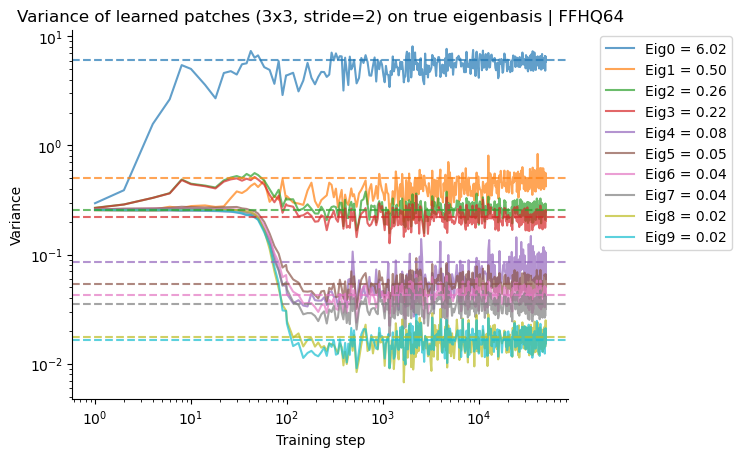

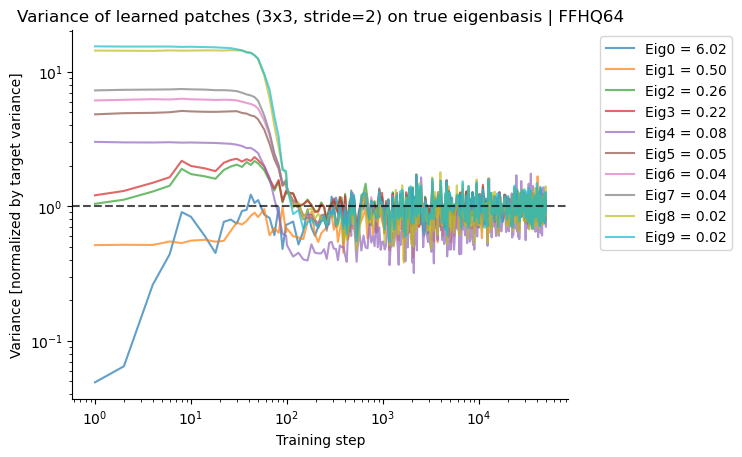

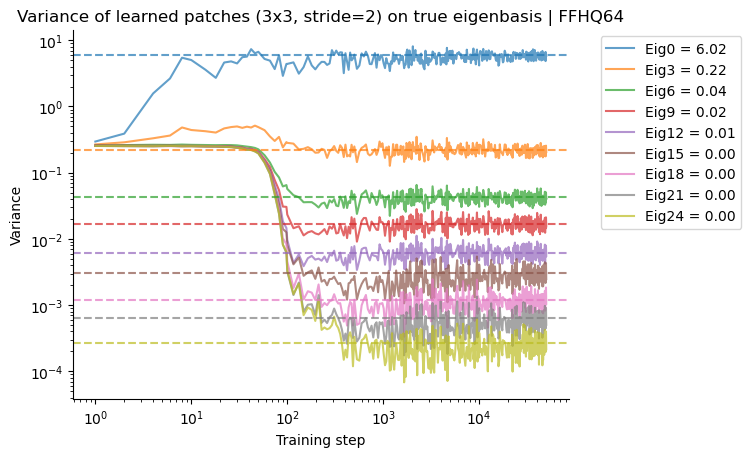

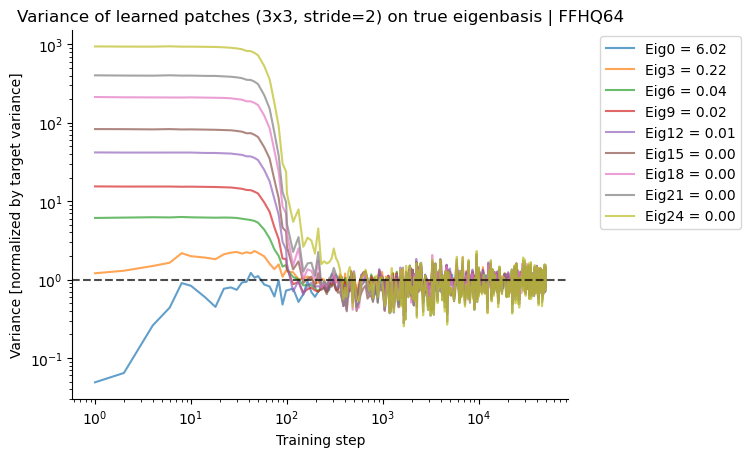

In [60]:
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval, slice(None, 10, 1), patch_size, patch_stride, savedir)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval, slice(None, 27, 3), patch_size, patch_stride, savedir)
# plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval, slice(None, 100, 10), patch_size, patch_stride, savedir)

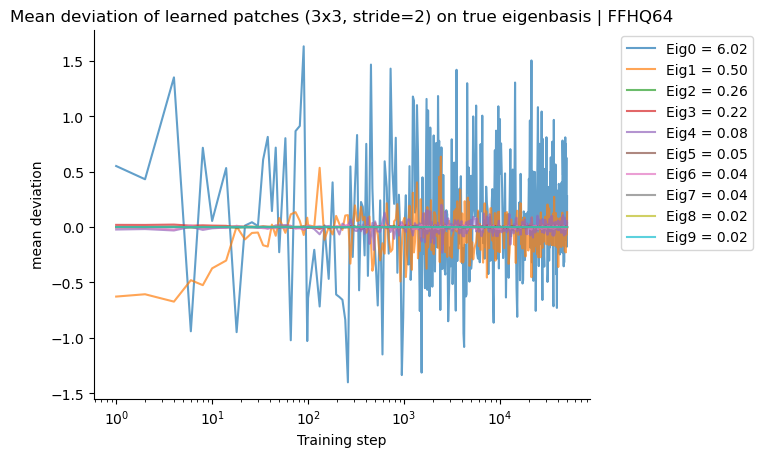

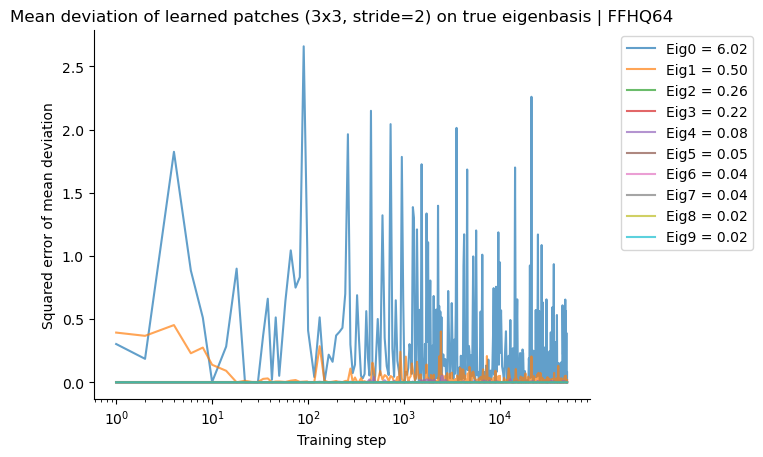

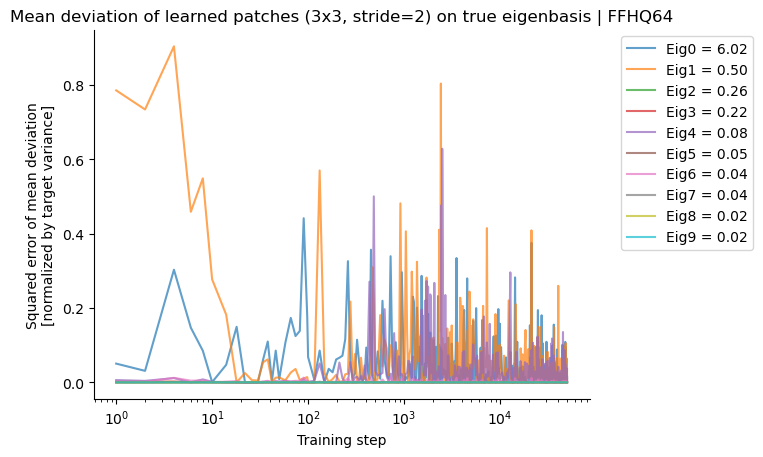

In [78]:
plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean, patch_eigvec, patch_eigval, slice(None, 10, 1), patch_size, patch_stride, savedir)


### patch 6x6, stride 3

In [79]:
patch_size, patch_stride = 6, 3
patch_mean, patch_cov, patch_eigval, patch_eigvec, \
    mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj = \
    process_patch_mean_cov_statistics(Xtsr, sample_store, savedir, patch_size=patch_size, patch_stride=patch_stride, device="cuda", imgshape=(3, 64, 64))

patch_cov.shape: torch.Size([108]) computed on 70000 images


  0%|          | 0/348 [00:00<?, ?it/s]

Saved to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/FFHQ_UNet_CNN_EDM_4blocks_wide64_attn_pilot_fixednorm/sample_patch_6x6_stride_3_cov_true_eigenbasis_diag_traj.pkl


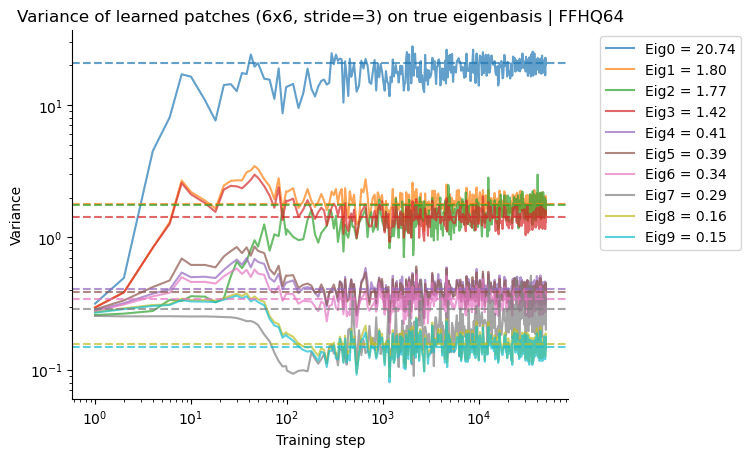

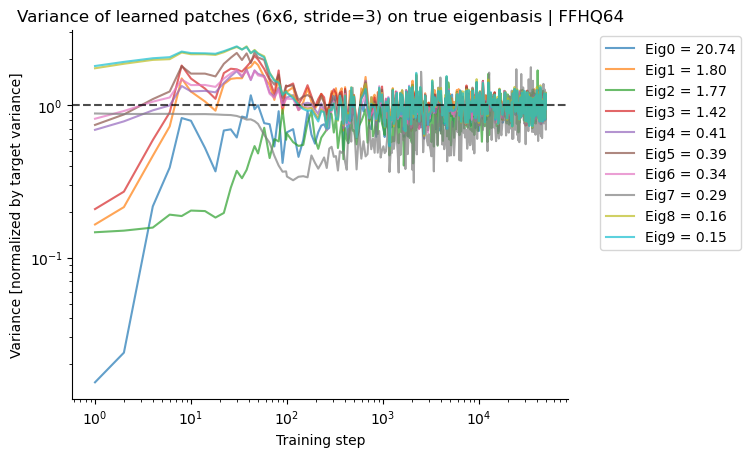

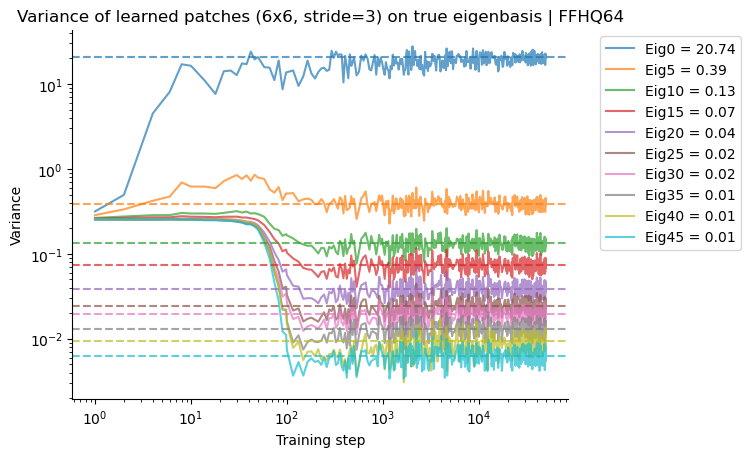

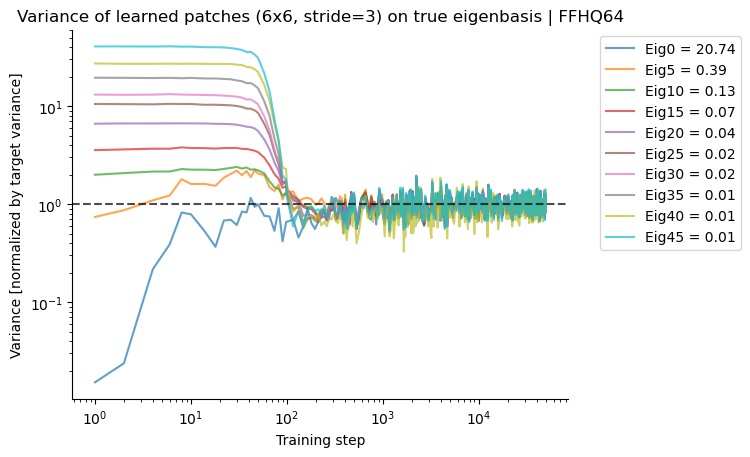

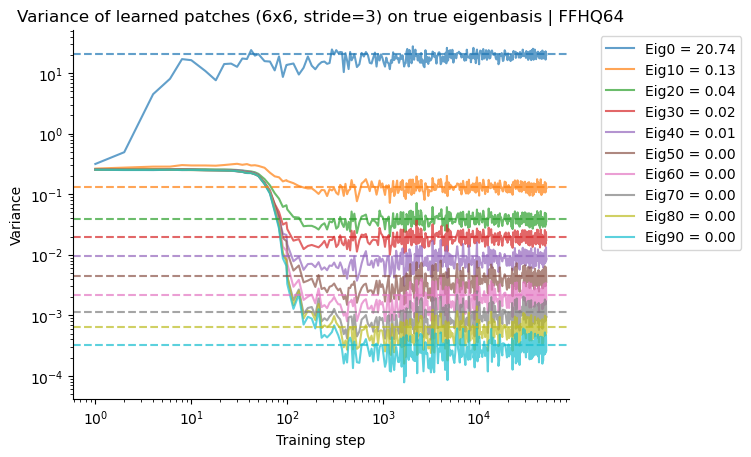

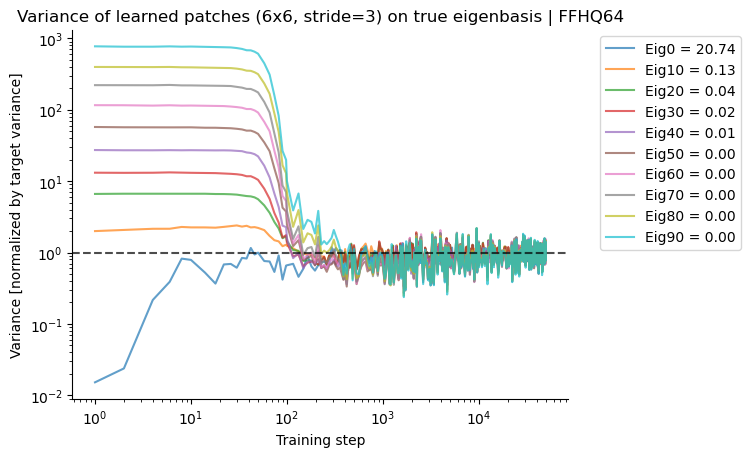

In [81]:
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval, slice(None, 10, 1), patch_size, patch_stride, savedir)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval, slice(None, 50, 5), patch_size, patch_stride, savedir)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval, slice(None, 100, 10), patch_size, patch_stride, savedir)

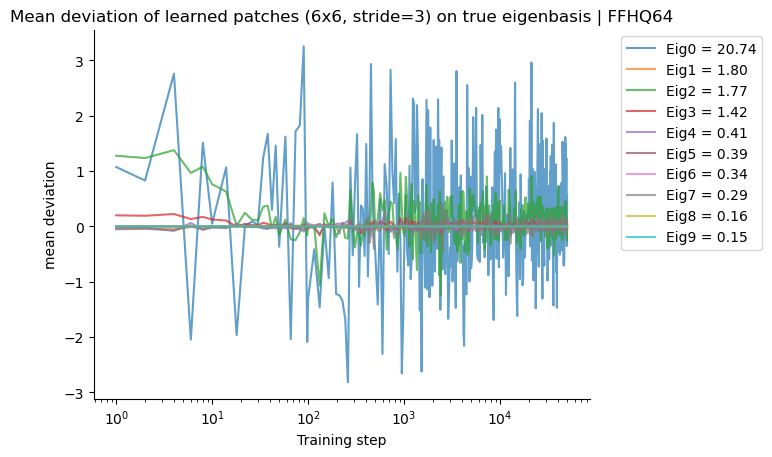

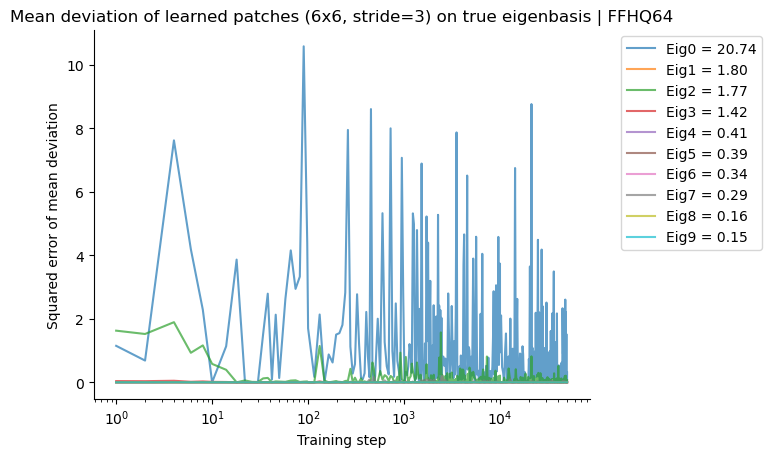

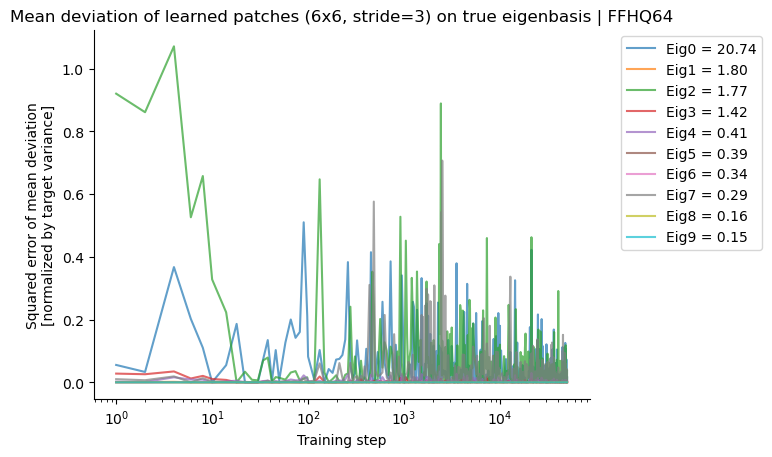

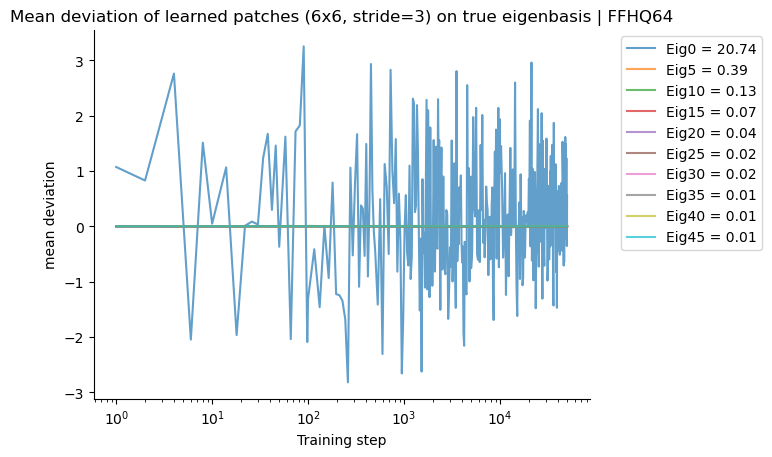

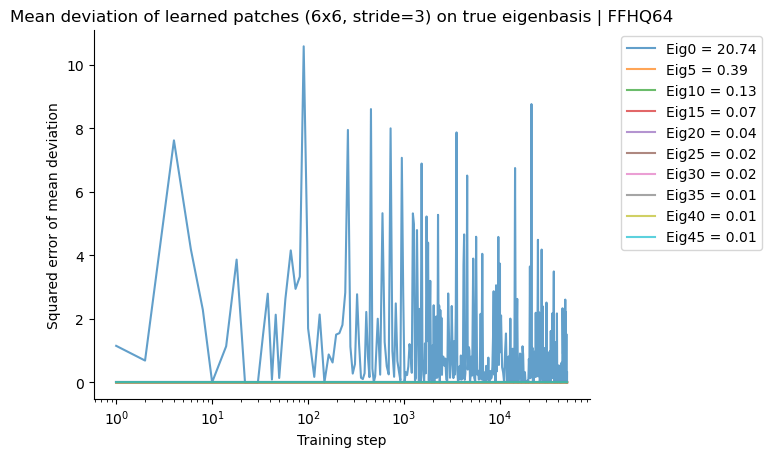

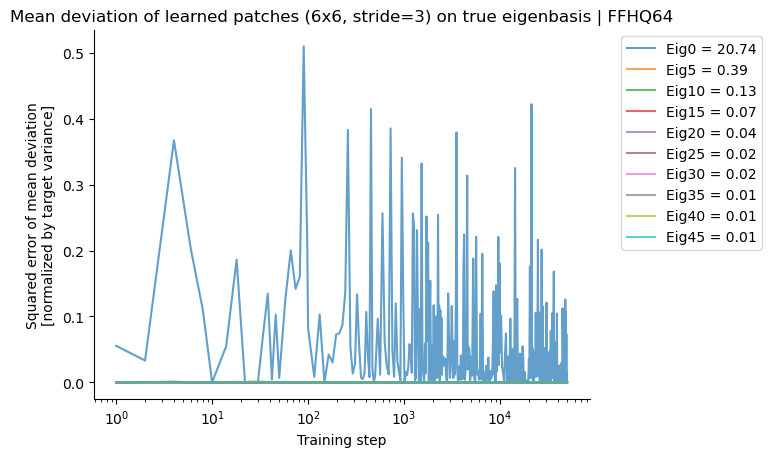

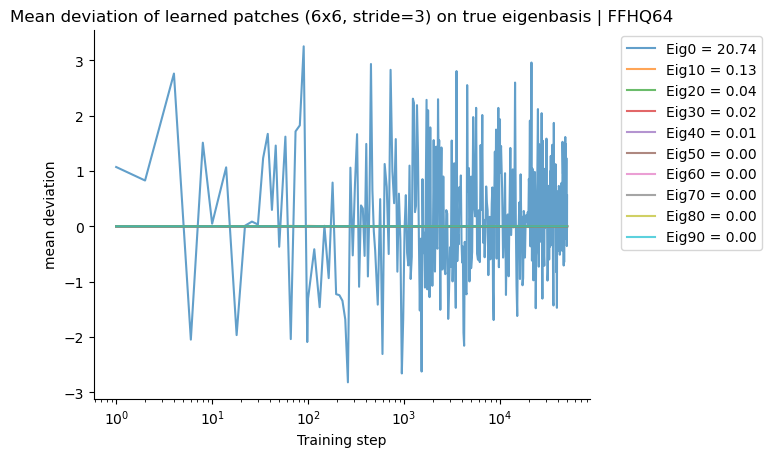

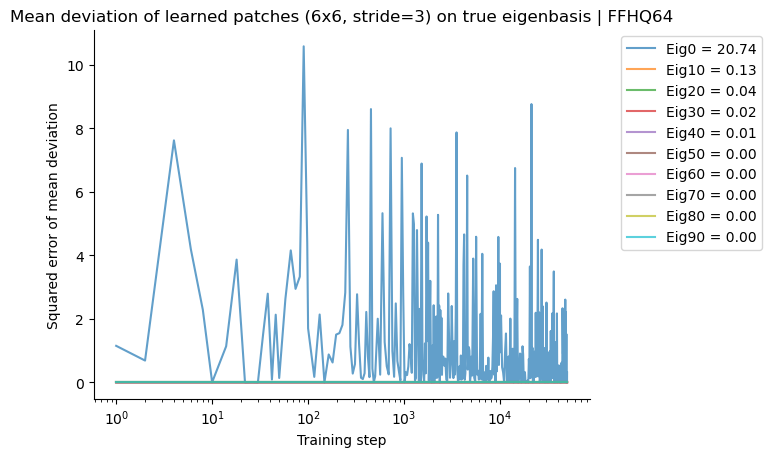

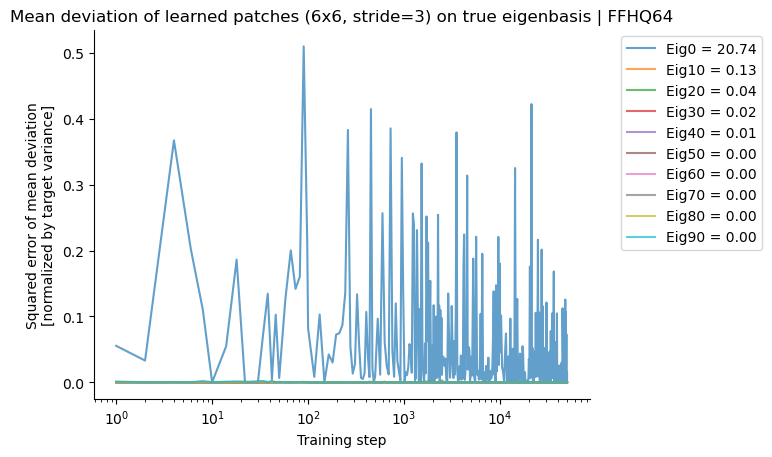

In [80]:
plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean, patch_eigvec, patch_eigval, slice(None, 10, 1), patch_size, patch_stride, savedir)
plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean, patch_eigvec, patch_eigval, slice(None, 50, 5), patch_size, patch_stride, savedir)
plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean, patch_eigvec, patch_eigval, slice(None, 100, 10), patch_size, patch_stride, savedir)

### patch 8x8, stride 4

In [83]:
patch_size, patch_stride = 8, 4
patch_mean, patch_cov, patch_eigval, patch_eigvec, \
    mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj = \
    process_patch_mean_cov_statistics(Xtsr, sample_store, savedir, patch_size=patch_size, patch_stride=patch_stride, device="cuda", imgshape=(3, 64, 64))

patch_cov.shape: torch.Size([192]) computed on 70000 images


  0%|          | 0/348 [00:00<?, ?it/s]

Saved to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/FFHQ_UNet_CNN_EDM_4blocks_wide64_attn_pilot_fixednorm/sample_patch_8x8_stride_4_cov_true_eigenbasis_diag_traj.pkl


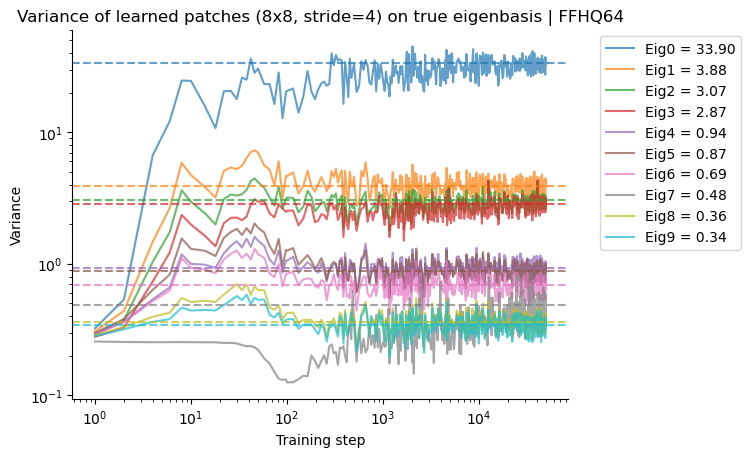

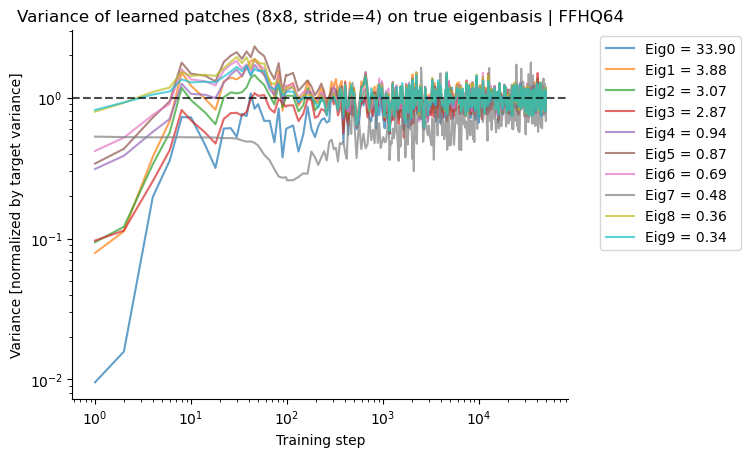

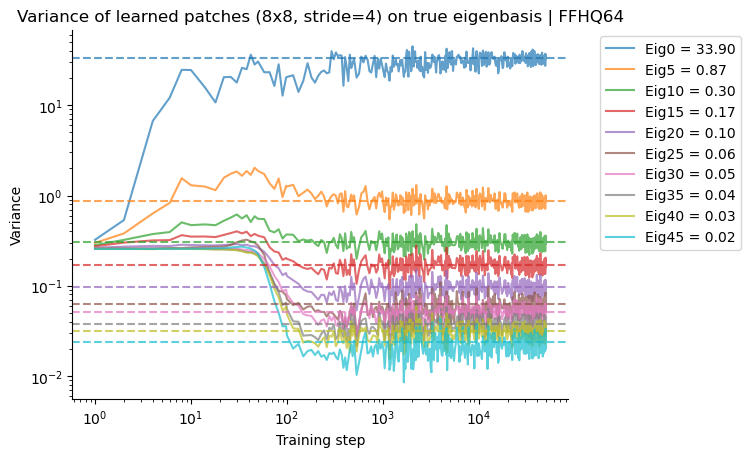

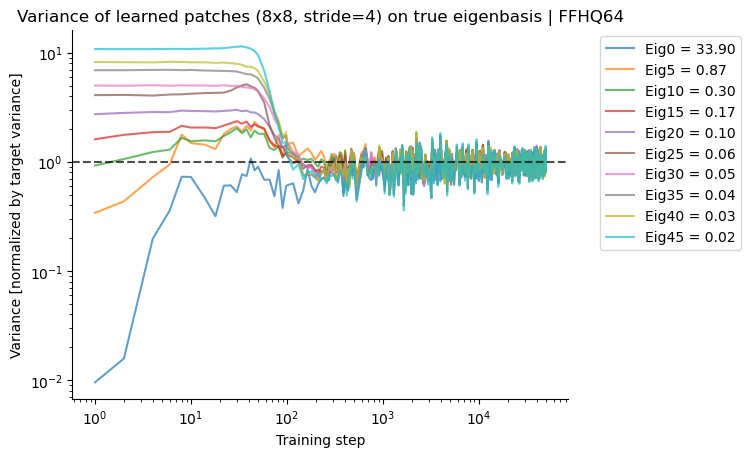

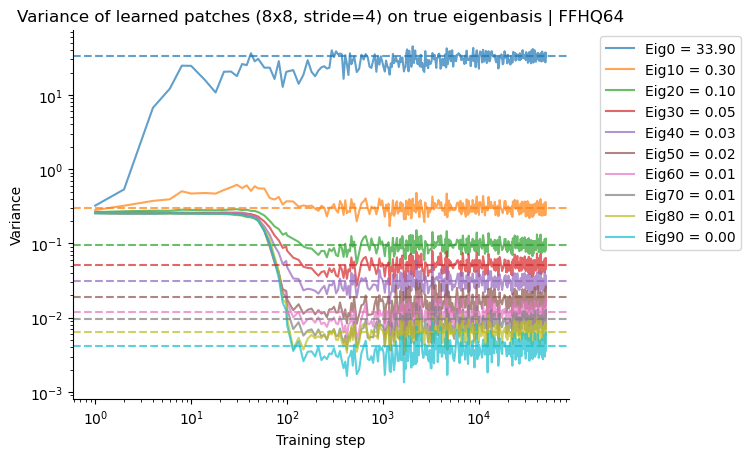

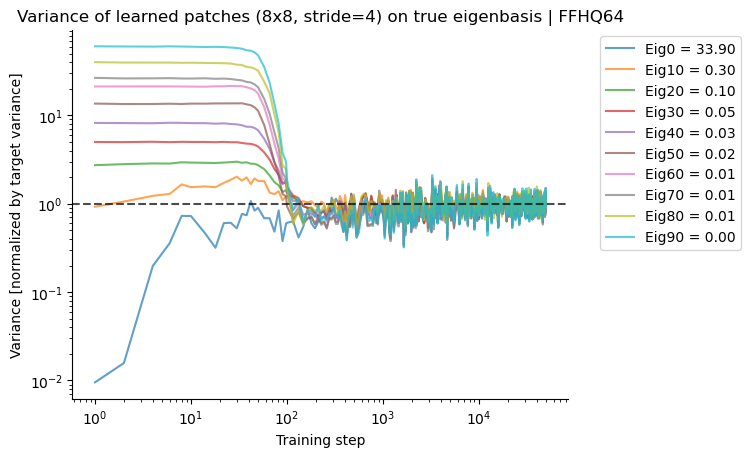

In [84]:
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval, slice(None, 10, 1), patch_size, patch_stride, savedir)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval, slice(None, 50, 5), patch_size, patch_stride, savedir)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval, slice(None, 100, 10), patch_size, patch_stride, savedir)

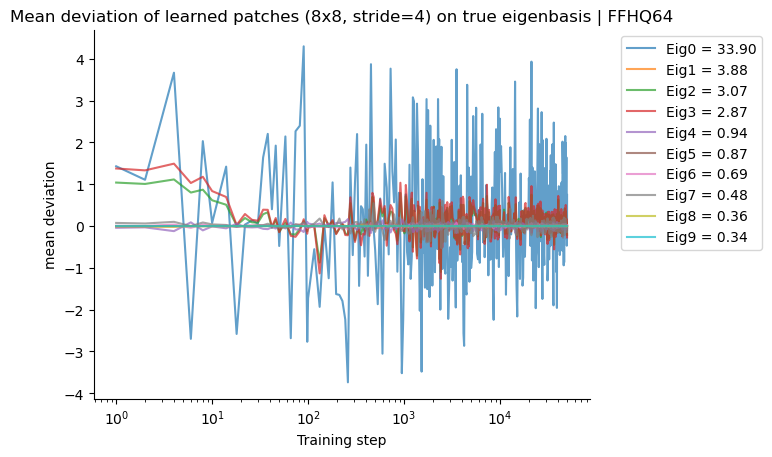

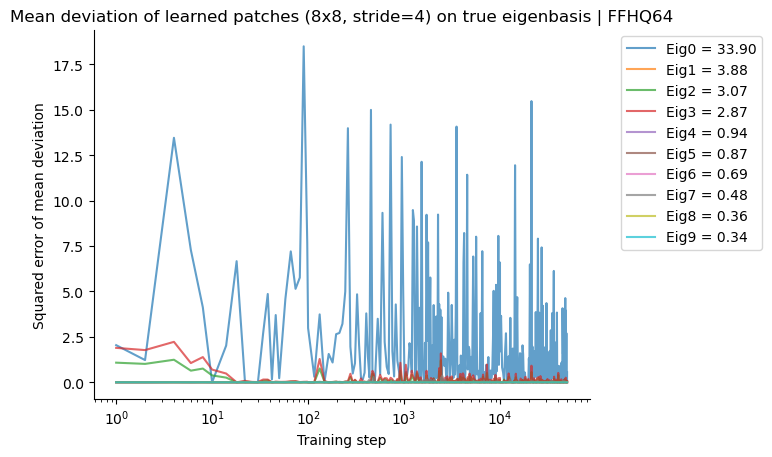

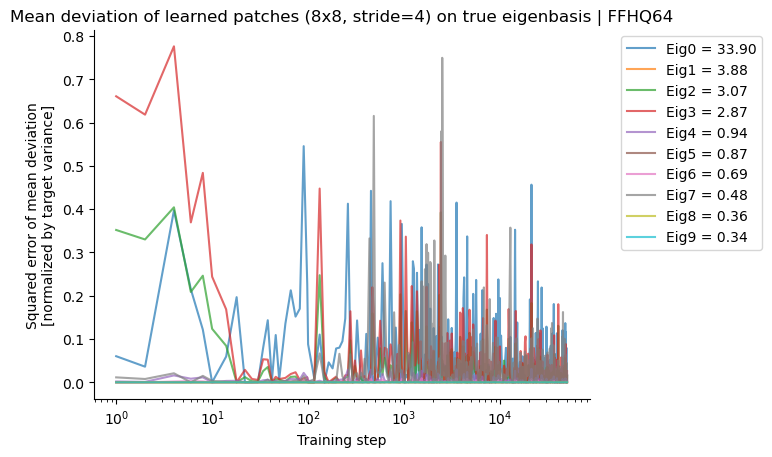

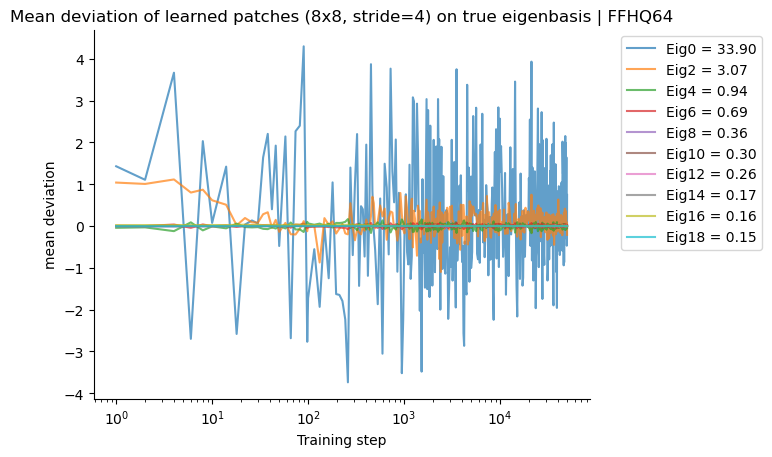

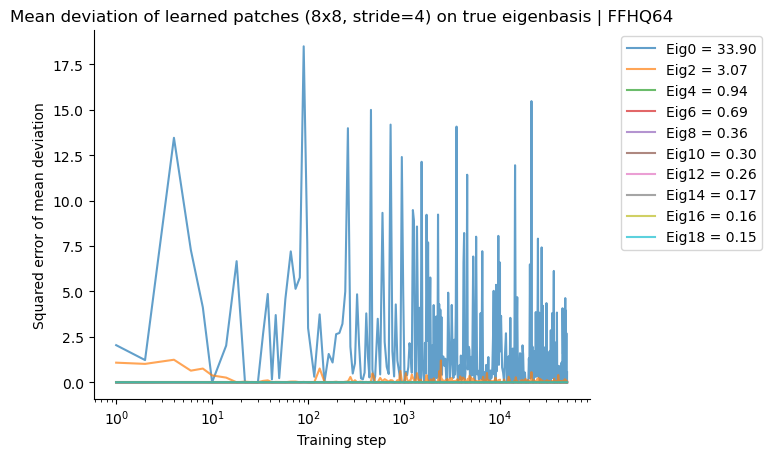

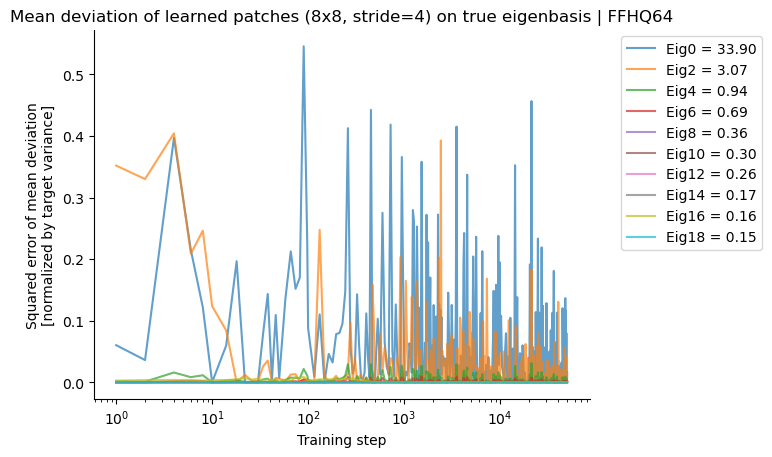

In [85]:
plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean, patch_eigvec, patch_eigval, slice(None, 10, 1), patch_size, patch_stride, savedir)
plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean, patch_eigvec, patch_eigval, slice(None, 20, 2), patch_size, patch_stride, savedir)

### Patch 16x16, stride 4

In [ ]:
patch_size, patch_stride = 16, 4 
patch_mean, patch_cov, patch_eigval, patch_eigvec, \
    mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj = \
    process_patch_mean_cov_statistics(Xtsr, sample_store, savedir, patch_size=patch_size, patch_stride=patch_stride, device="cuda", imgshape=(3, 64, 64))

In [ ]:
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval, slice(None, 10, 1), patch_size, patch_stride, savedir)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval, slice(None, 50, 5), patch_size, patch_stride, savedir)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval, slice(None, 100, 10), patch_size, patch_stride, savedir)

In [ ]:
plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean, patch_eigvec, patch_eigval, slice(None, 10, 1), patch_size, patch_stride, savedir)
plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean, patch_eigvec, patch_eigval, slice(None, 20, 2), patch_size, patch_stride, savedir)

### Whole image statistics

In [12]:
device = "cuda"

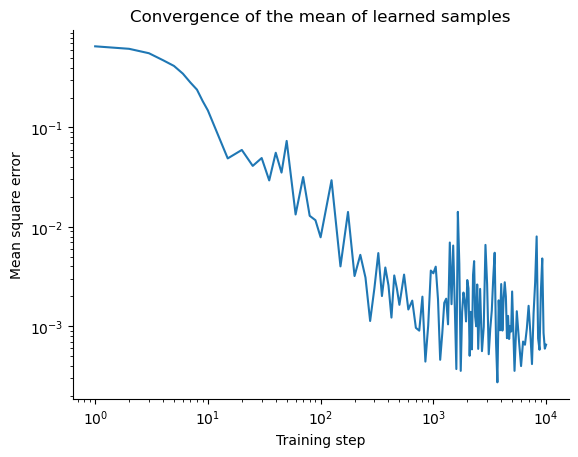

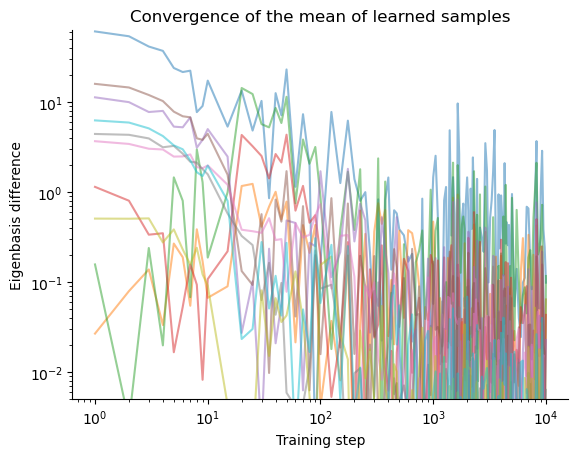

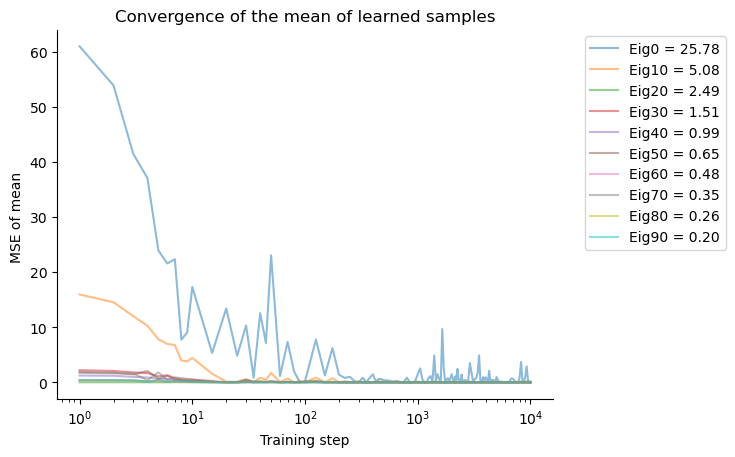

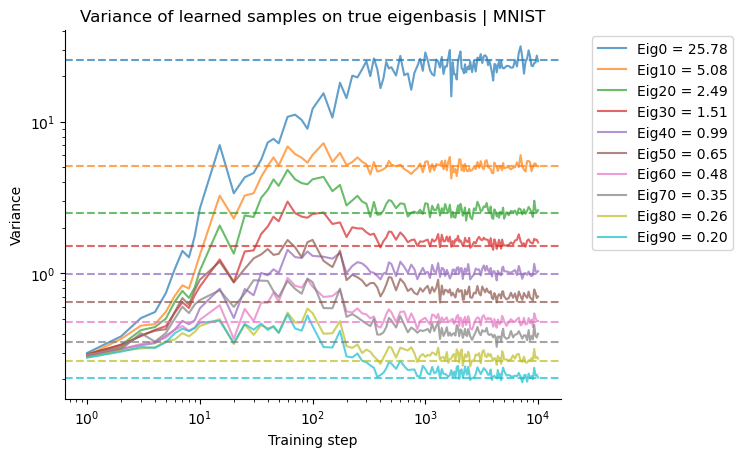

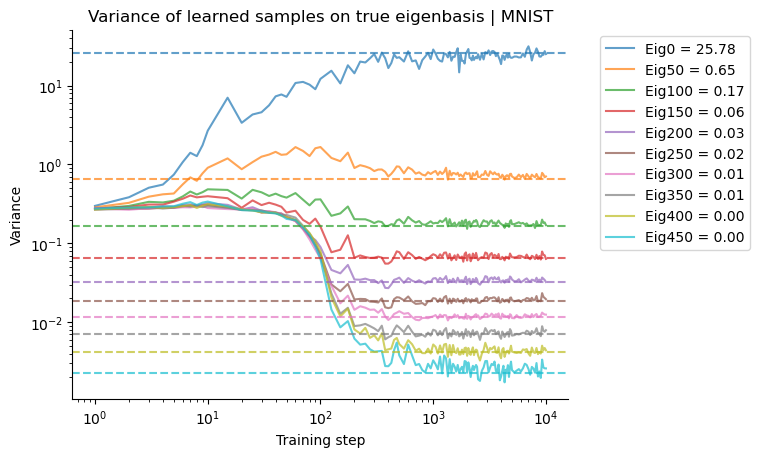

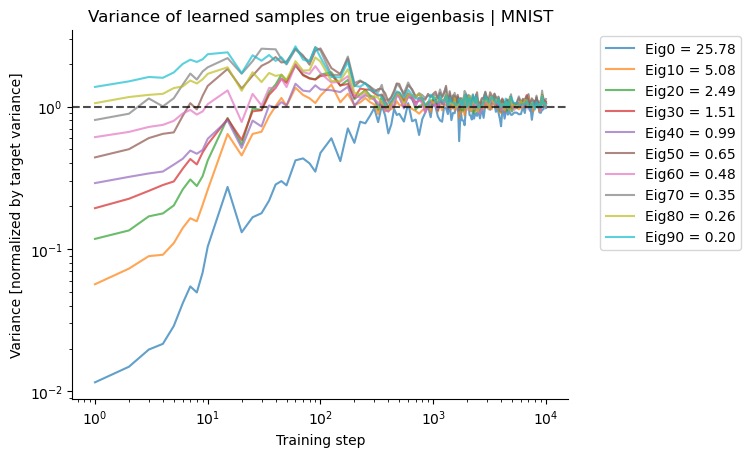

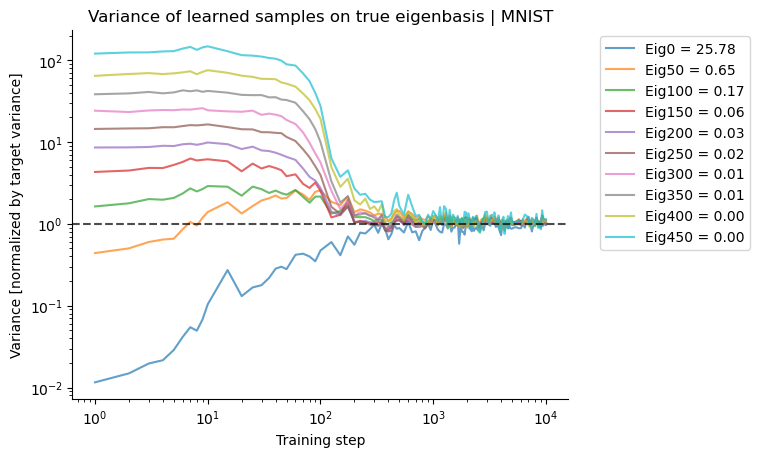

In [15]:

# plot the convergence of the mean 
mean_X_loss = (mean_x_sample_traj.to(device) - X_mean.to(device)).pow(2).mean(dim=1)
plt.figure()
plt.plot(step_slice, mean_X_loss.cpu().numpy(), label="MSE of mean")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Mean square error")
plt.title("Convergence of the mean of learned samples")
saveallforms(savedir, "sample_mean_convergence_MSE_traj_loglog")
plt.show()

# %%
# Project the difference of mean on the true eigenbasis
mean_X_diff_true_basis = (mean_x_sample_traj.to(device) - X_mean.to(device)) @ rot.to(device)
MSE_X_diff_true_basis = mean_X_diff_true_basis.pow(2).cpu()
slice2plot = slice(None, 20, 2)
plt.figure()
plt.plot(step_slice, MSE_X_diff_true_basis.numpy()[:, slice2plot], label="Eigenbasis difference", alpha=0.5)
plt.ylim(5E-3, None)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Eigenbasis difference")
plt.title("Convergence of the mean of learned samples")
saveallforms(savedir, "sample_mean_convergence_eigenbasis_MSE_traj_top20_loglog")
plt.show()

# %%
# Project the difference of mean on the true eigenbasis
mean_X_diff_true_basis = (mean_x_sample_traj.to(device) - X_mean.to(device)) @ rot.to(device)
MSE_X_diff_true_basis = mean_X_diff_true_basis.pow(2).cpu()
slice2plot = slice(None, 100, 10)
plt.figure()
plt.plot(step_slice, MSE_X_diff_true_basis.numpy()[:, slice2plot], label="Eigenbasis difference", alpha=0.5)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("MSE of mean ")
plt.title("Convergence of the mean of learned samples")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, "sample_mean_convergence_eigenbasis_MSE_traj_top100")
plt.show()

# %%
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 100, 10)
plt.figure()
plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_raw_top100")
plt.show()

# %%
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 500, 50)
plt.figure()
plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_raw_top500")
plt.show()

# %%
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 100, 10)
plt.figure()
plt.plot(step_slice, diag_cov_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_top100")
plt.show()

# %%
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 500, 50)
plt.figure()
plt.plot(step_slice, diag_cov_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_top500")
plt.show()

### Patch statisics 


In [ ]:

images = Xtsr.view(Xtsr.shape[0], 1, 32, 32)
patches = extract_patches(images, patch_size=3, patch_stride=3)
patch_shape = patches.shape[1:]
patch_dim = np.prod(patch_shape)

torch.Size([6000000, 1, 3, 3])

### Smallest patch 3x3 stride 1

In [40]:
patch_size, patch_stride = 3, 1
images = Xtsr.view(Xtsr.shape[0], 1, 32, 32)
patches = extract_patches(images, patch_size=patch_size, patch_stride=patch_stride)
patch_shape = patches.shape[1:]
patch_dim = np.prod(patch_shape)

patch_cov = torch.cov(patches.view(patches.shape[0], -1).T)
patch_eigval, patch_eigvec = torch.linalg.eigh(patch_cov)
patch_eigval = patch_eigval.flip(0)
patch_eigvec = patch_eigvec.flip(1)

imgshape = (1, 32, 32)
true_cov_eigs = diag_var.cpu()
mean_x_patch_sample_traj = []
cov_x_patch_sample_traj = []
diag_cov_x_patch_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final_patches = extract_patches(x_final.view(x_final.shape[0], *imgshape), patch_size=patch_size, patch_stride=patch_stride)
    x_final_patches = x_final_patches.view(x_final_patches.shape[0], -1)
    mean_x_patch_sample = x_final_patches.mean(dim=0)
    cov_x_patch_sample = torch.cov(x_final_patches.T)
    mean_x_patch_sample_traj.append(mean_x_patch_sample.cpu())
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_patch_sample_true_eigenbasis = patch_eigvec.T @ cov_x_patch_sample @ patch_eigvec
    diag_cov_x_patch_sample_true_eigenbasis = torch.diag(cov_x_patch_sample_true_eigenbasis)
    diag_cov_x_patch_sample_true_eigenbasis_traj.append(diag_cov_x_patch_sample_true_eigenbasis.cpu())
    cov_x_patch_sample_traj.append(cov_x_patch_sample.cpu())
    
mean_x_patch_sample_traj = torch.stack(mean_x_patch_sample_traj).cpu()
cov_x_patch_sample_traj = torch.stack(cov_x_patch_sample_traj).cpu()
diag_cov_x_patch_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_patch_sample_true_eigenbasis_traj).cpu()

  0%|          | 0/124 [00:00<?, ?it/s]

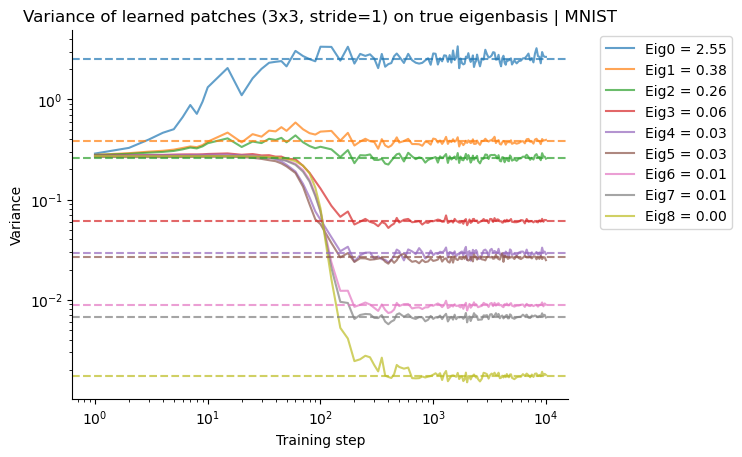

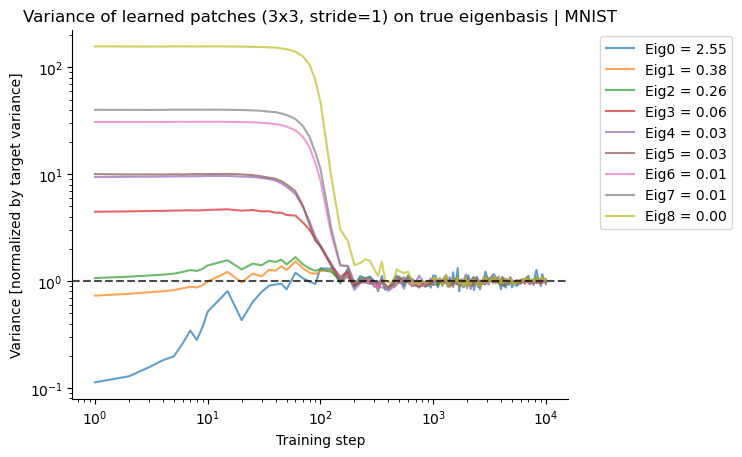

In [41]:
plt.figure()
slice2plot = slice(None, 9, 1)
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw")
plt.show()

plt.figure()
slice2plot = slice(None, 9, 1)
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized")
plt.show()

### Smallest patch 3x3

In [35]:
patch_size, patch_stride = 3, 3
images = Xtsr.view(Xtsr.shape[0], 1, 32, 32)
patches = extract_patches(images, patch_size=patch_size, patch_stride=patch_stride)
patch_shape = patches.shape[1:]
patch_dim = np.prod(patch_shape)

patch_cov = torch.cov(patches.view(patches.shape[0], -1).T)
patch_eigval, patch_eigvec = torch.linalg.eigh(patch_cov)
patch_eigval = patch_eigval.flip(0)
patch_eigvec = patch_eigvec.flip(1)

imgshape = (1, 32, 32)
true_cov_eigs = diag_var.cpu()
mean_x_patch_sample_traj = []
cov_x_patch_sample_traj = []
diag_cov_x_patch_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final_patches = extract_patches(x_final.view(x_final.shape[0], *imgshape), patch_size=patch_size, patch_stride=patch_stride)
    x_final_patches = x_final_patches.view(x_final_patches.shape[0], -1)
    mean_x_patch_sample = x_final_patches.mean(dim=0)
    cov_x_patch_sample = torch.cov(x_final_patches.T)
    mean_x_patch_sample_traj.append(mean_x_patch_sample.cpu())
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_patch_sample_true_eigenbasis = patch_eigvec.T @ cov_x_patch_sample @ patch_eigvec
    diag_cov_x_patch_sample_true_eigenbasis = torch.diag(cov_x_patch_sample_true_eigenbasis)
    diag_cov_x_patch_sample_true_eigenbasis_traj.append(diag_cov_x_patch_sample_true_eigenbasis.cpu())
    cov_x_patch_sample_traj.append(cov_x_patch_sample.cpu())
    
mean_x_patch_sample_traj = torch.stack(mean_x_patch_sample_traj).cpu()
cov_x_patch_sample_traj = torch.stack(cov_x_patch_sample_traj).cpu()
diag_cov_x_patch_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_patch_sample_true_eigenbasis_traj).cpu()

  0%|          | 0/124 [00:00<?, ?it/s]

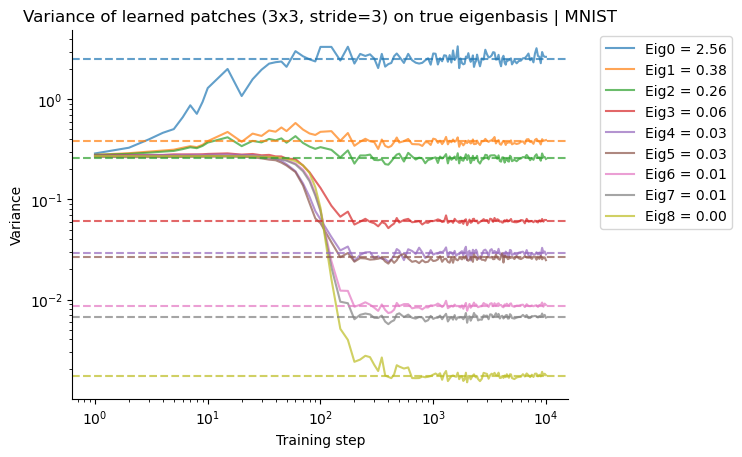

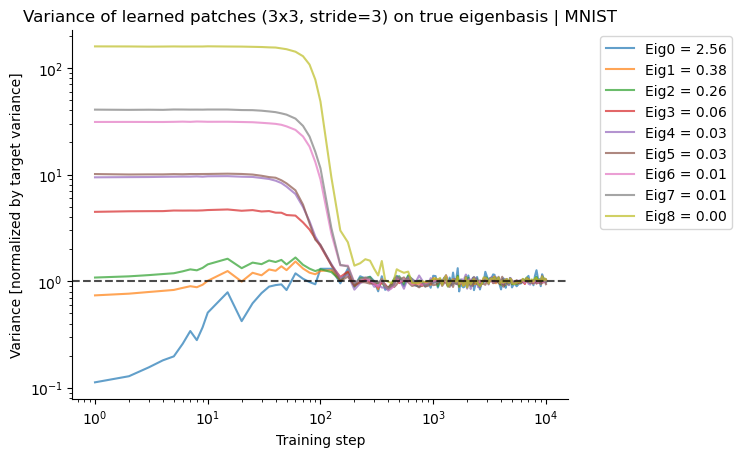

In [36]:
plt.figure()
slice2plot = slice(None, 9, 1)
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw")
plt.show()

plt.figure()
slice2plot = slice(None, 9, 1)
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized")
plt.show()

### Larger patches 6x6

In [31]:
patch_size, patch_stride = 6, 3
images = Xtsr.view(Xtsr.shape[0], 1, 32, 32)
patches = extract_patches(images, patch_size=patch_size, patch_stride=patch_stride)
patch_shape = patches.shape[1:]
patch_dim = np.prod(patch_shape)

patch_cov = torch.cov(patches.view(patches.shape[0], -1).T)
patch_eigval, patch_eigvec = torch.linalg.eigh(patch_cov)
patch_eigval = patch_eigval.flip(0)
patch_eigvec = patch_eigvec.flip(1)
imgshape = (1, 32, 32)
true_cov_eigs = diag_var.cpu()
mean_x_patch_sample_traj = []
cov_x_patch_sample_traj = []
diag_cov_x_patch_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final_patches = extract_patches(x_final.view(x_final.shape[0], *imgshape), patch_size=patch_size, patch_stride=patch_stride)
    x_final_patches = x_final_patches.view(x_final_patches.shape[0], -1)
    mean_x_patch_sample = x_final_patches.mean(dim=0)
    cov_x_patch_sample = torch.cov(x_final_patches.T)
    mean_x_patch_sample_traj.append(mean_x_patch_sample.cpu())
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_patch_sample_true_eigenbasis = patch_eigvec.T @ cov_x_patch_sample @ patch_eigvec
    diag_cov_x_patch_sample_true_eigenbasis = torch.diag(cov_x_patch_sample_true_eigenbasis)
    diag_cov_x_patch_sample_true_eigenbasis_traj.append(diag_cov_x_patch_sample_true_eigenbasis.cpu())
    cov_x_patch_sample_traj.append(cov_x_patch_sample.cpu())
    
mean_x_patch_sample_traj = torch.stack(mean_x_patch_sample_traj).cpu()
cov_x_patch_sample_traj = torch.stack(cov_x_patch_sample_traj).cpu()
diag_cov_x_patch_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_patch_sample_true_eigenbasis_traj).cpu()

  0%|          | 0/124 [00:00<?, ?it/s]

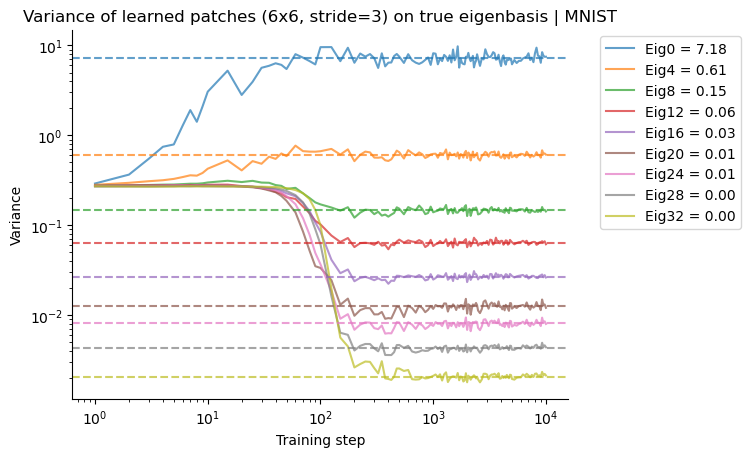

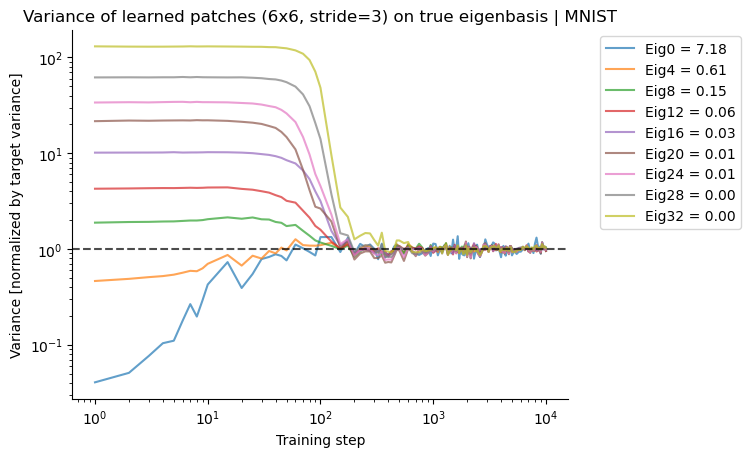

In [33]:

slice2plot = slice(None, 36, 4)
plt.figure()
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw")
plt.show()

plt.figure()
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized")
plt.show()

### Larger patches 9x9

In [37]:
patch_size, patch_stride = 9, 3
images = Xtsr.view(Xtsr.shape[0], 1, 32, 32)
patches = extract_patches(images, patch_size=patch_size, patch_stride=patch_stride)
patch_shape = patches.shape[1:]
patch_dim = np.prod(patch_shape)

patch_cov = torch.cov(patches.view(patches.shape[0], -1).T)
patch_eigval, patch_eigvec = torch.linalg.eigh(patch_cov)
patch_eigval = patch_eigval.flip(0)
patch_eigvec = patch_eigvec.flip(1)
imgshape = (1, 32, 32)
true_cov_eigs = diag_var.cpu()
mean_x_patch_sample_traj = []
cov_x_patch_sample_traj = []
diag_cov_x_patch_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final_patches = extract_patches(x_final.view(x_final.shape[0], *imgshape), patch_size=patch_size, patch_stride=patch_stride)
    x_final_patches = x_final_patches.view(x_final_patches.shape[0], -1)
    mean_x_patch_sample = x_final_patches.mean(dim=0)
    cov_x_patch_sample = torch.cov(x_final_patches.T)
    mean_x_patch_sample_traj.append(mean_x_patch_sample.cpu())
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_patch_sample_true_eigenbasis = patch_eigvec.T @ cov_x_patch_sample @ patch_eigvec
    diag_cov_x_patch_sample_true_eigenbasis = torch.diag(cov_x_patch_sample_true_eigenbasis)
    diag_cov_x_patch_sample_true_eigenbasis_traj.append(diag_cov_x_patch_sample_true_eigenbasis.cpu())
    cov_x_patch_sample_traj.append(cov_x_patch_sample.cpu())
    
mean_x_patch_sample_traj = torch.stack(mean_x_patch_sample_traj).cpu()
cov_x_patch_sample_traj = torch.stack(cov_x_patch_sample_traj).cpu()
diag_cov_x_patch_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_patch_sample_true_eigenbasis_traj).cpu()

  0%|          | 0/124 [00:00<?, ?it/s]

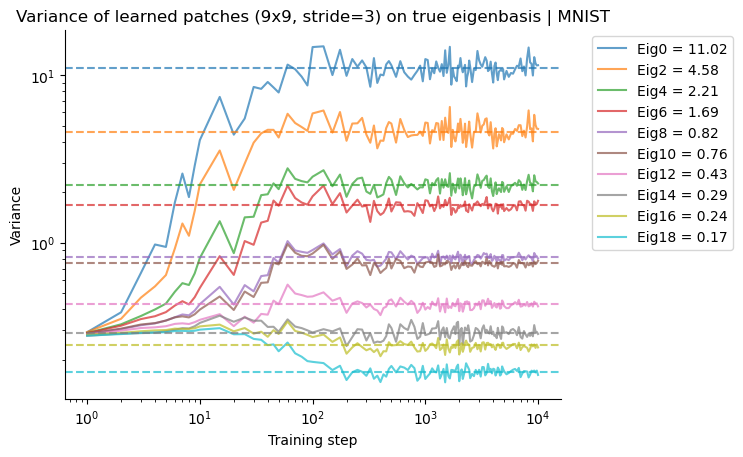

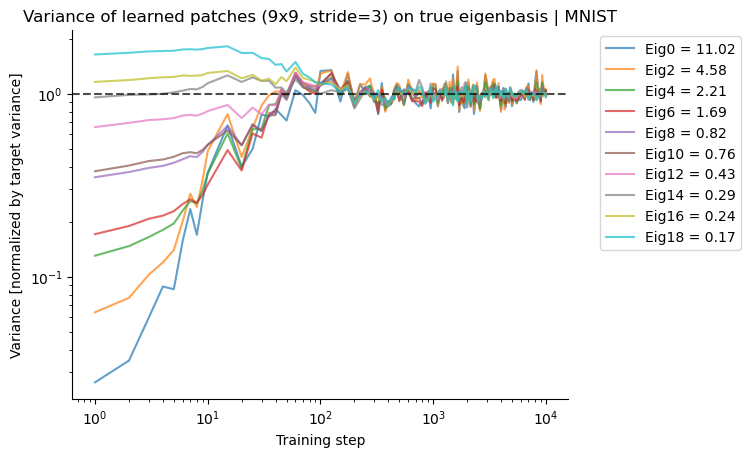

In [39]:
slice2plot = slice(None, 20, 2)
plt.figure()
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw_top20")
plt.show()

plt.figure()
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized_top20")
plt.show()

In [46]:
savedir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_4blocks_noattn'

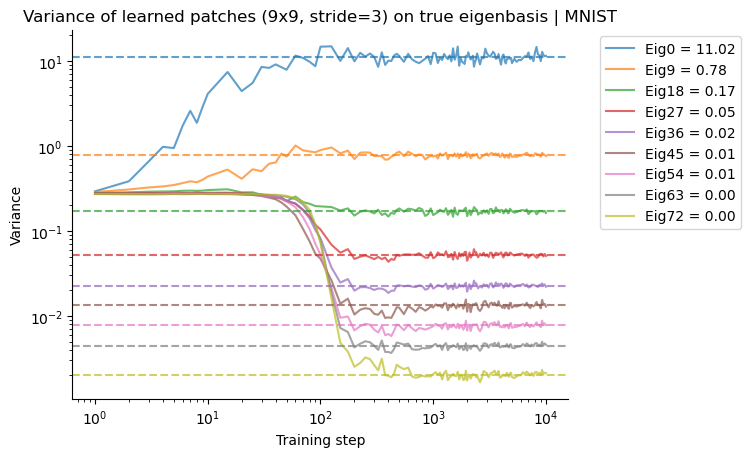

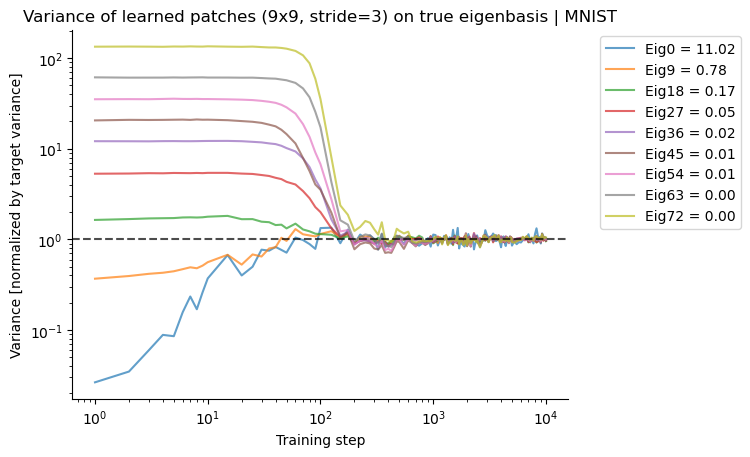

In [38]:
slice2plot = slice(None, 81, 9)
plt.figure()
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw")
plt.show()

plt.figure()
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized")
plt.show()

### Larger patches 16x16

In [42]:
patch_size, patch_stride = 16, 4
images = Xtsr.view(Xtsr.shape[0], 1, 32, 32)
patches = extract_patches(images, patch_size=patch_size, patch_stride=patch_stride)
patch_shape = patches.shape[1:]
patch_dim = np.prod(patch_shape)

patch_cov = torch.cov(patches.view(patches.shape[0], -1).T)
patch_eigval, patch_eigvec = torch.linalg.eigh(patch_cov)
patch_eigval = patch_eigval.flip(0)
patch_eigvec = patch_eigvec.flip(1)
imgshape = (1, 32, 32)
true_cov_eigs = diag_var.cpu()
mean_x_patch_sample_traj = []
cov_x_patch_sample_traj = []
diag_cov_x_patch_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final_patches = extract_patches(x_final.view(x_final.shape[0], *imgshape), patch_size=patch_size, patch_stride=patch_stride)
    x_final_patches = x_final_patches.view(x_final_patches.shape[0], -1)
    mean_x_patch_sample = x_final_patches.mean(dim=0)
    cov_x_patch_sample = torch.cov(x_final_patches.T)
    mean_x_patch_sample_traj.append(mean_x_patch_sample.cpu())
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_patch_sample_true_eigenbasis = patch_eigvec.T @ cov_x_patch_sample @ patch_eigvec
    diag_cov_x_patch_sample_true_eigenbasis = torch.diag(cov_x_patch_sample_true_eigenbasis)
    diag_cov_x_patch_sample_true_eigenbasis_traj.append(diag_cov_x_patch_sample_true_eigenbasis.cpu())
    cov_x_patch_sample_traj.append(cov_x_patch_sample.cpu())
    
mean_x_patch_sample_traj = torch.stack(mean_x_patch_sample_traj).cpu()
cov_x_patch_sample_traj = torch.stack(cov_x_patch_sample_traj).cpu()
diag_cov_x_patch_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_patch_sample_true_eigenbasis_traj).cpu()

  0%|          | 0/124 [00:00<?, ?it/s]

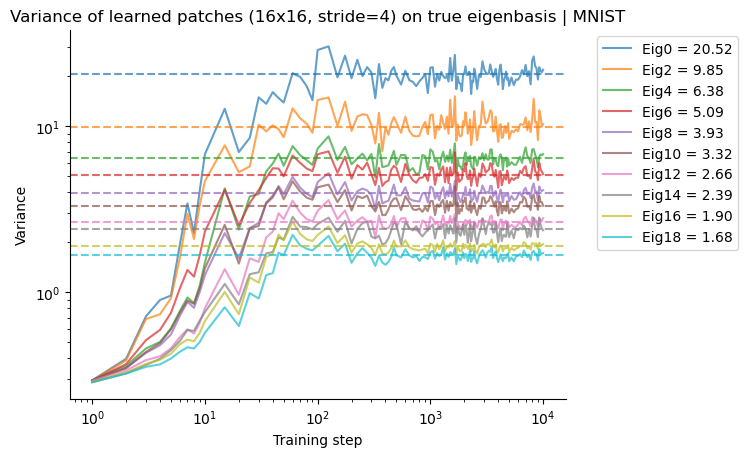

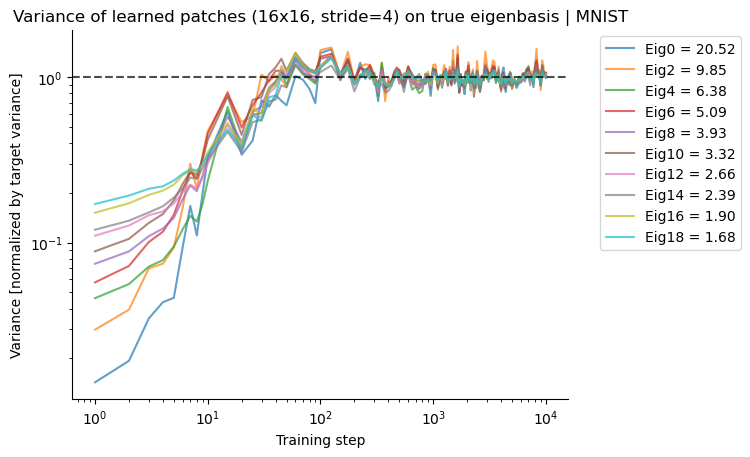

In [43]:
slice2plot = slice(None, 20, 2)
plt.figure()
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw_top20")
plt.show()

plt.figure()
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized_top20")
plt.show()

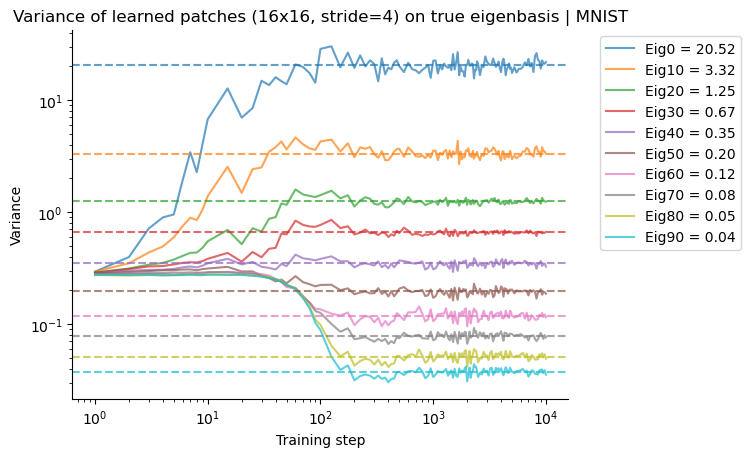

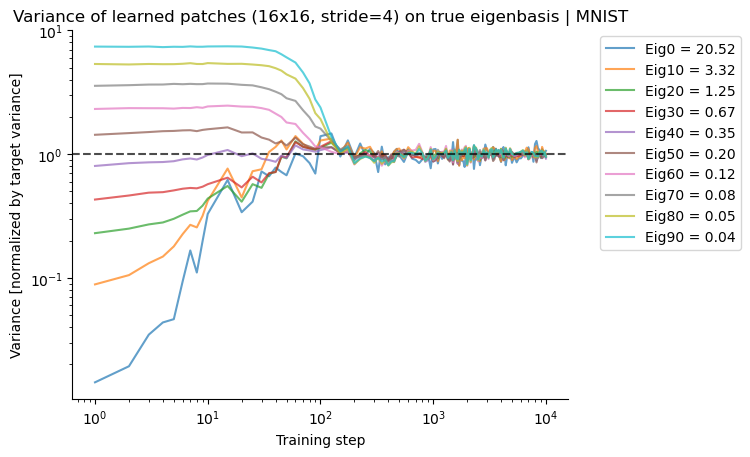

In [44]:
slice2plot = slice(None, 100, 10)
plt.figure()
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw")
plt.show()

plt.figure()
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized")
plt.show()

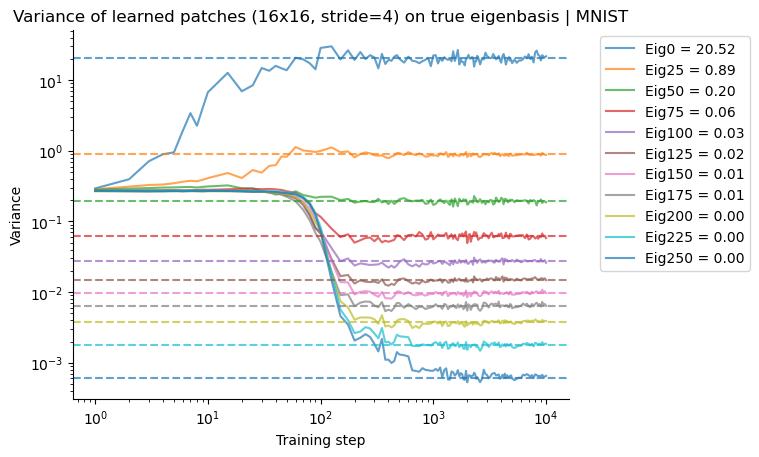

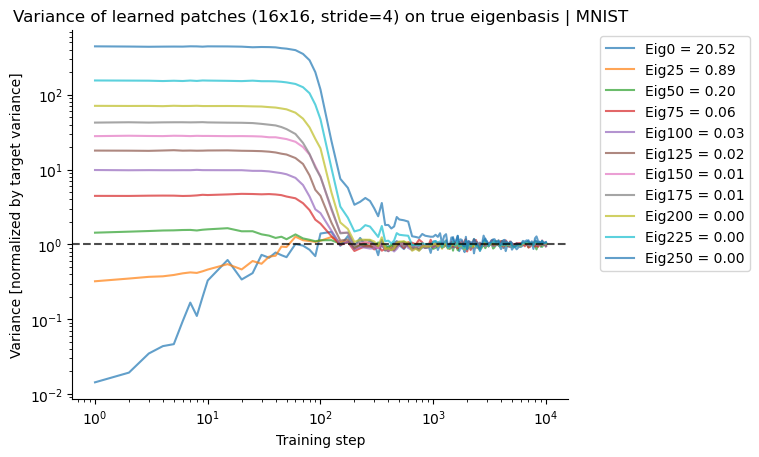

In [45]:
slice2plot = slice(None, 256, 25)
plt.figure()
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw")
plt.show()

plt.figure()
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized")
plt.show()

### Scratch 

In [ ]:
imgshape = (3, 64, 64)
patch_size, patch_stride = 8, 4
images = Xtsr.view(Xtsr.shape[0], *imgshape)
patches = extract_patches(images, patch_size=patch_size, patch_stride=patch_stride)
patch_shape = patches.shape[1:]
patch_dim = np.prod(patch_shape)

patch_cov = torch.cov(patches.view(patches.shape[0], -1).T)
patch_eigval, patch_eigvec = torch.linalg.eigh(patch_cov)
patch_eigval = patch_eigval.flip(0)
patch_eigvec = patch_eigvec.flip(1)

In [ ]:
patch_eigvec = patch_eigvec.to(device)
mean_x_patch_sample_traj = []
cov_x_patch_sample_traj = []
diag_cov_x_patch_sample_true_eigenbasis_traj = []
step_slice = sorted([*sample_store.keys()])
for training_step in tqdm(step_slice):
    x_final = sample_store[training_step]
    x_final_patches = extract_patches(x_final.view(x_final.shape[0], *imgshape), patch_size=patch_size, patch_stride=patch_stride)
    x_final_patches = x_final_patches.view(x_final_patches.shape[0], -1)
    mean_x_patch_sample = x_final_patches.mean(dim=0)
    cov_x_patch_sample = torch.cov(x_final_patches.T)
    mean_x_patch_sample_traj.append(mean_x_patch_sample.cpu())
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_patch_sample_true_eigenbasis = patch_eigvec.T @ cov_x_patch_sample @ patch_eigvec
    diag_cov_x_patch_sample_true_eigenbasis = torch.diag(cov_x_patch_sample_true_eigenbasis)
    diag_cov_x_patch_sample_true_eigenbasis_traj.append(diag_cov_x_patch_sample_true_eigenbasis.cpu())
    cov_x_patch_sample_traj.append(cov_x_patch_sample.cpu())
    
mean_x_patch_sample_traj = torch.stack(mean_x_patch_sample_traj).cpu()
cov_x_patch_sample_traj = torch.stack(cov_x_patch_sample_traj).cpu()
diag_cov_x_patch_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_patch_sample_true_eigenbasis_traj).cpu()

  0%|          | 0/348 [00:00<?, ?it/s]

In [ ]:
pkl.dump({"diag_cov_x_patch_sample_true_eigenbasis_traj": diag_cov_x_patch_sample_true_eigenbasis_traj, 
          "mean_x_patch_sample_traj": mean_x_patch_sample_traj,
          "cov_x_patch_sample_traj": cov_x_patch_sample_traj,
          "patch_cov": patch_cov.cpu(),
          "patch_eigval": patch_eigval.cpu(),
          "patch_eigvec": patch_eigvec.cpu(),
          "step_slice": step_slice}, 
         open(f"{savedir}/sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj.pkl", "wb"))

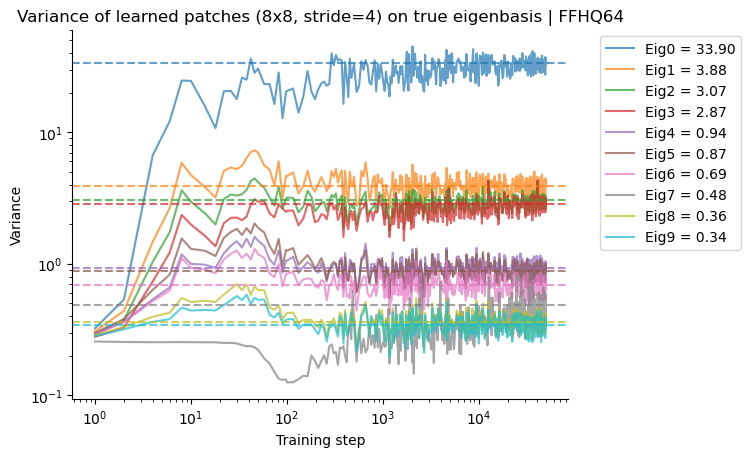

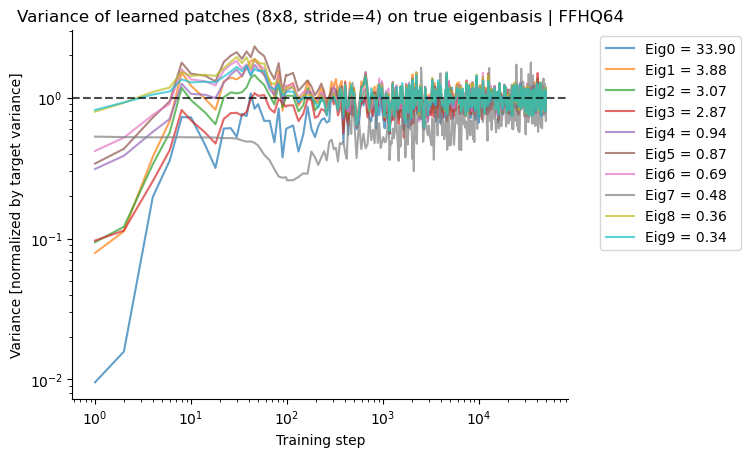

In [ ]:
plt.figure()
ndim = patch_eigval.shape[0]
slice2plot = slice(None, 10, 1)
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | FFHQ64")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw_top10")
plt.show()

plt.figure()
slice2plot = slice(None, 10, 1)
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | FFHQ64")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized_top10")
plt.show()

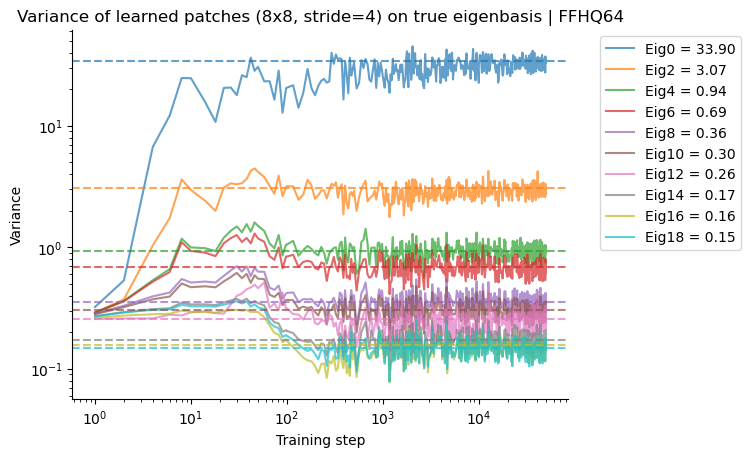

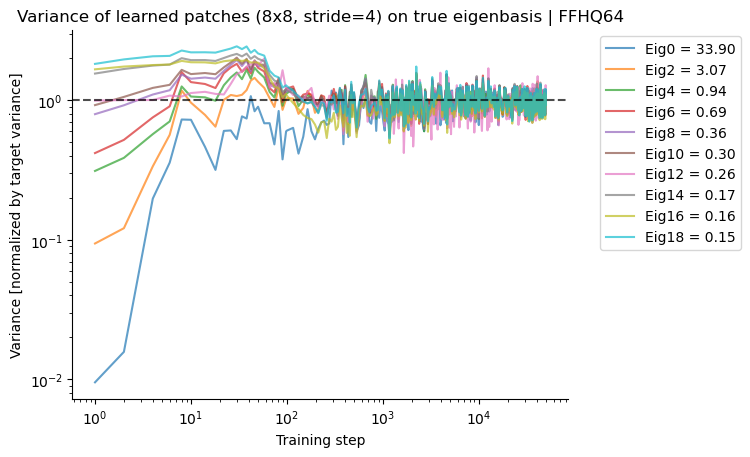

In [ ]:
plt.figure()
ndim = patch_eigval.shape[0]
slice2plot = slice(None, 20, 2)
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | FFHQ64")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw_top20")
plt.show()

plt.figure()
slice2plot = slice(None, 20, 2)
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | FFHQ64")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized_top20")
plt.show()

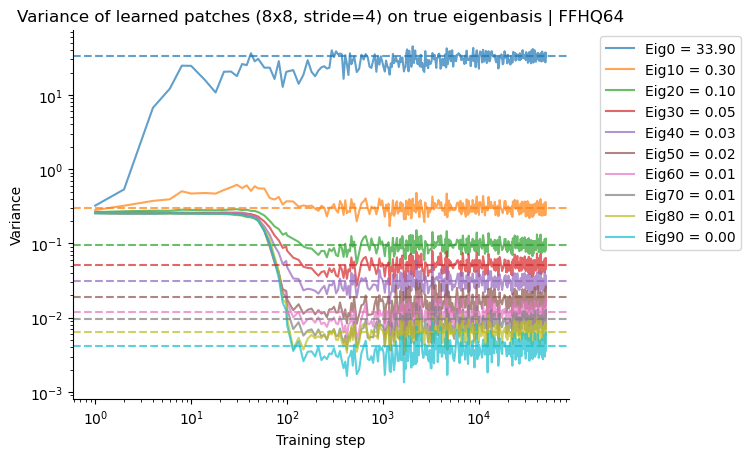

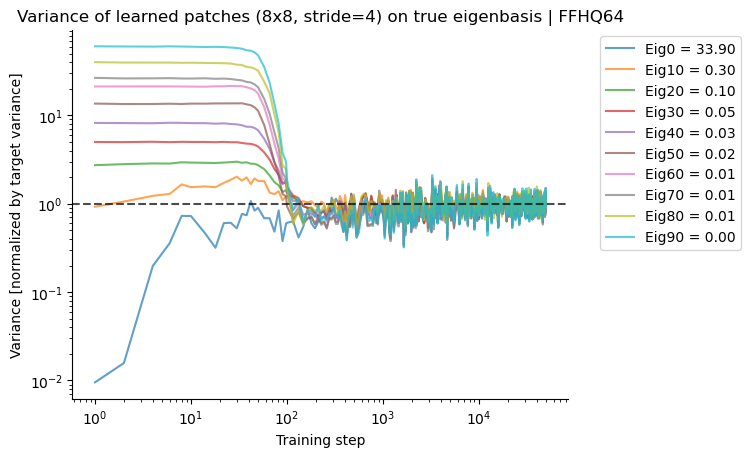

In [ ]:
plt.figure()
ndim = patch_eigval.shape[0]
slice2plot = slice(None, 100, 10)
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | FFHQ64")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw_top100")
plt.show()

plt.figure()
slice2plot = slice(None, 100, 10)
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | FFHQ64")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized_top100")
plt.show()